# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは -1.137252 なので、うまく計算出来ているように思える。

--- FCI Matrix ---
[[-1.83186365e+00 -5.22608557e-16 -4.67083728e-16  1.81210462e-01]
 [-5.22608557e-16 -1.06466723e+00  1.81210462e-01 -1.64624263e-17]
 [-4.67083728e-16  1.81210462e-01 -1.06466723e+00  8.67705089e-17]
 [ 1.81210462e-01 -1.64624263e-17  8.67705089e-17 -2.52486193e-01]]

---- Initial walkers ----
1 walkers on 0th determinant


 12%|██████████▊                                                                               | 1803/15000 [00:00<00:00, 18024.77it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-1.116759
  1 walkers on 0th determinant
Step 1000: Walkers=9, Shift=0.00000, E_proj=-1.116759
  9 walkers on 0th determinant
Step 2000: Walkers=87, Shift=0.00000, E_proj=-1.125492
  83 walkers on 0th determinant
  -4 walkers on 3th determinant


 24%|█████████████████████▉                                                                     | 3606/15000 [00:00<00:02, 4465.44it/s]

Step 3000: Walkers=397, Shift=-0.66597, E_proj=-1.134830
  361 walkers on 0th determinant
  -36 walkers on 3th determinant


 30%|███████████████████████████▍                                                               | 4521/15000 [00:01<00:05, 1917.83it/s]

Step 4000: Walkers=1105, Shift=-1.09316, E_proj=-1.139665
  981 walkers on 0th determinant
  -124 walkers on 3th determinant


 36%|████████████████████████████████▊                                                          | 5402/15000 [00:03<00:09, 1014.05it/s]

Step 5000: Walkers=1967, Shift=-1.37116, E_proj=-1.137957
  1761 walkers on 0th determinant
  -206 walkers on 3th determinant


 41%|█████████████████████████████████████▌                                                      | 6121/15000 [00:05<00:15, 563.77it/s]

Step 6000: Walkers=2746, Shift=-1.55390, E_proj=-1.136034
  2482 walkers on 0th determinant
  -264 walkers on 3th determinant


 47%|███████████████████████████████████████████▎                                                | 7064/15000 [00:08<00:26, 295.24it/s]

Step 7000: Walkers=3390, Shift=-1.67837, E_proj=-1.136105
  3063 walkers on 0th determinant
  -327 walkers on 3th determinant


 54%|█████████████████████████████████████████████████▌                                          | 8076/15000 [00:12<00:27, 252.82it/s]

Step 8000: Walkers=3900, Shift=-1.73421, E_proj=-1.138688
  3479 walkers on 0th determinant
  -421 walkers on 3th determinant


 60%|███████████████████████████████████████████████████████▌                                    | 9062/15000 [00:16<00:24, 241.99it/s]

Step 9000: Walkers=4197, Shift=-1.78109, E_proj=-1.137982
  3757 walkers on 0th determinant
  -440 walkers on 3th determinant


 67%|████████████████████████████████████████████████████████████▉                              | 10052/15000 [00:20<00:21, 225.52it/s]

Step 10000: Walkers=4433, Shift=-1.80505, E_proj=-1.137486
  3978 walkers on 0th determinant
  -455 walkers on 3th determinant


 74%|███████████████████████████████████████████████████████████████████                        | 11064/15000 [00:24<00:17, 223.61it/s]

Step 11000: Walkers=4546, Shift=-1.82835, E_proj=-1.138952
  4050 walkers on 0th determinant
  -496 walkers on 3th determinant


 80%|█████████████████████████████████████████████████████████████████████████                  | 12053/15000 [00:29<00:13, 222.95it/s]

Step 12000: Walkers=4526, Shift=-1.82505, E_proj=-1.136864
  4074 walkers on 0th determinant
  -452 walkers on 3th determinant


 87%|███████████████████████████████████████████████████████████████████████████████▏           | 13053/15000 [00:33<00:09, 210.67it/s]

Step 13000: Walkers=4590, Shift=-1.83050, E_proj=-1.138466
  4099 walkers on 0th determinant
  -491 walkers on 3th determinant


 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 14047/15000 [00:38<00:04, 218.68it/s]

Step 14000: Walkers=4628, Shift=-1.82178, E_proj=-1.138807
  4126 walkers on 0th determinant
  -502 walkers on 3th determinant


100%|███████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:42<00:00, 349.03it/s]



---- Walkers (result) ----
4166 walkers on 0th determinant
-468 walkers on 3th determinant


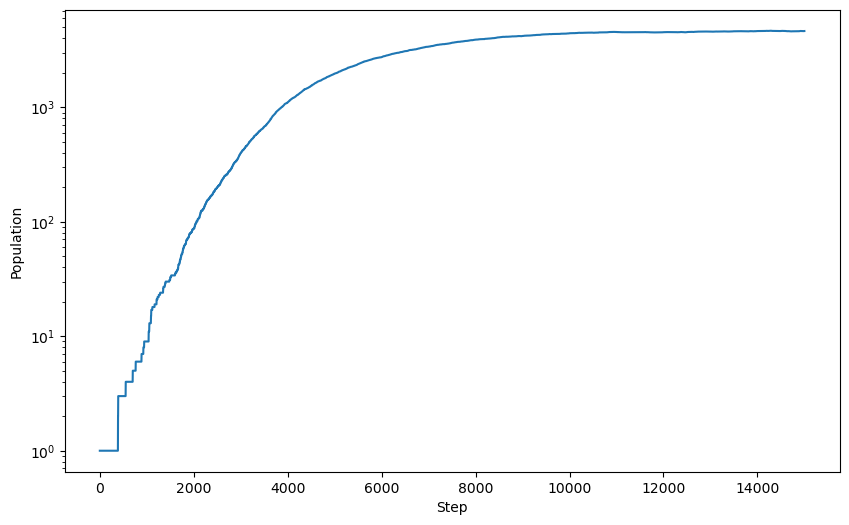

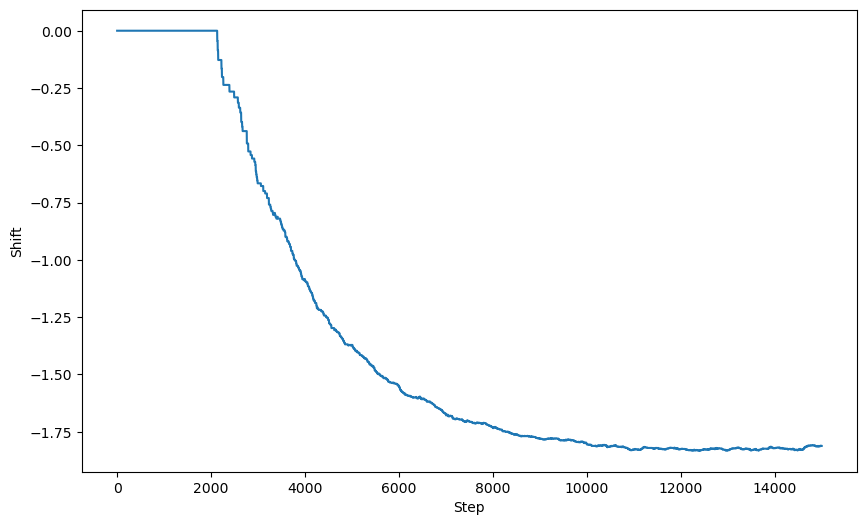

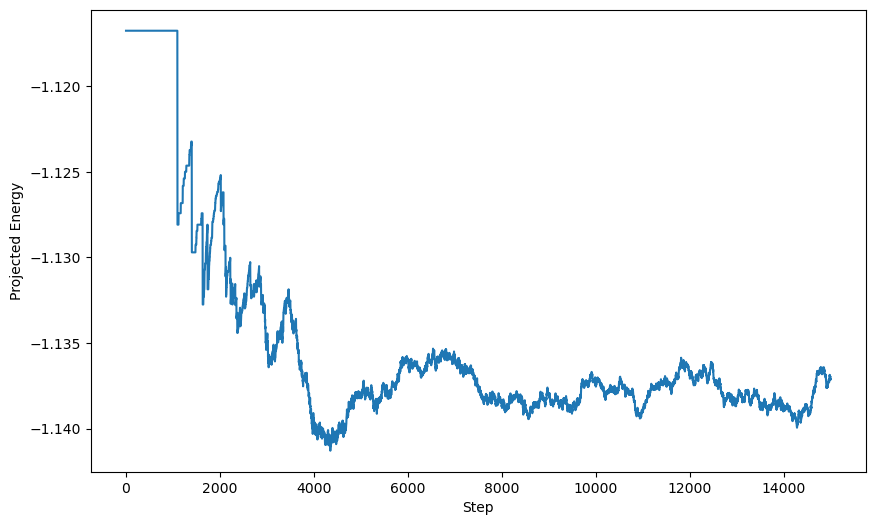

------------------------------
Final FCIQMC Energy: -1.138266 Ha


In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    """PySCFを使ってFCIハミルトニアン行列全体を生成する"""
    # 1. RHF計算
    mf = scf.RHF(mol).run(verbose=0)
    h1 = mf.get_hcore()
    h2 = mf._eri
    
    # 2. 分子軌道(MO)積分へ変換
    norb = mf.mo_coeff.shape[1]
    nelec = mol.nelectron
    h1_mo = np.dot(mf.mo_coeff.T, np.dot(h1, mf.mo_coeff))
    h2_mo = ao2mo.kernel(mol, mf.mo_coeff)
    
    # 3. 全CIハミルトニアン行列の生成
    # 注意: H2/STO-3Gのような小規模系でのみ可能です。
    # 大規模系ではオンザフライで行列要素を計算する必要があります。
    cisolver = fci.direct_spin1.FCI(mol)
    h2_mo_restore = ao2mo.restore(1, h2_mo, norb)
    H_mat = fci.direct_spin1.pspace(h1_mo, h2_mo_restore, norb, nelec)[1]
    # TODO: E_HFを引いた形のKを使わない？    
    # return H_mat, mf.e_tot, norb, nelec
    return H_mat

    H_fci = fci.direct_spin1.pspace(h1, h2, norb, nelec, np=1225)[1]


def FCIQMC(shift=0, init_n_walker=1, n_steps=15000, step_starting_shift_upd=2000, shift_upd_interval=10,
           dt=0.001, damping=0.05):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて
    H2 分子（R = 0.74 Å）の基底状態エネルギーを推定する。

    Args:
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """
    
    # H2分子の定義 (0.74 Angstrom)
    mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
    H_mat = build_hamiltonian(mol)
    print(f"--- FCI Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps)):
        new_walkers = {}
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            # 通常は接続された決定基をランダムサンプリングするが、
            # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            
            for j in connected_dets:
                # 対角要素は自分自身への遷移を表すので処理しない
                if i == j: continue
                h_ij = row[j]

                # Spawning probability: Ps = dt * |H_ij|
                # 生成される数: sign(walker) * sign(-H_ij)
                # TODO: 分母のpgenは1？
                prob_spawn = dt * abs(h_ij)

                # 全てのwalkerに対して、spawnを試みる
                for k in range(n_i):            
                    if rng.random() <= prob_spawn:
                        # print(f'prob_spawn from {i} to {j}th determinant: ', prob_spawn)
                        if j not in new_walkers: new_walkers[j] = 0

                        n_spawn = 1
                        if prob_spawn >= 1:
                            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
                            n_spawn = prob_spawn_int + int(rng.random() < prob_spawn_frac) # 小数部分の確率でもう一つwalkerを追加で生成する

                        # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
                        if h_ij > 0:
                            new_walkers[j] += -np.sign(n_i) * n_spawn
                        else:
                            new_walkers[j] += np.sign(n_i) * n_spawn

            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            for k in range(abs(n_i)):
                if rng.random() <= abs(prob_death):
                    if prob_death > 0:
                        # prob_deathが正ならwalkerを一つ消滅させる
                        n_walker_on_D = sign * (abs(n_walker_on_D) - 1)
                    else:
                        # prob_deathが負ならwalkerを一つ複製する
                        n_walker_on_D = sign * (abs(n_walker_on_D) + 1)
            walkers[i] = n_walker_on_D

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        E_HF = diag_H[ref_det_idx]
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        # TODO: 論文にはない項を足している
        E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        # TODO: singles/doublesに限定する？
        
        if step % 1000 == 0:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                tqdm.write(f"  {v} walkers on {k}th determinant")

    E_est = np.mean(hist_energy[-1000:]) # 最後の1000ステップの平均
    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        print(f"{v} walkers on {k}th determinant")

    return E_est, hist_population, hist_shift, hist_energy



# --- 実行 ---
E_est, hist_population, hist_shift, hist_energy = FCIQMC()

plt.figure(figsize=(10, 6))
plt.plot(hist_population)
plt.xlabel('Step')
plt.ylabel('Population')
plt.yscale('log')

plt.figure(figsize=(10, 6))
plt.plot(hist_shift)
plt.xlabel('Step')
plt.ylabel('Shift')

plt.figure(figsize=(10, 6))
plt.plot(hist_energy)
plt.xlabel('Step')
plt.ylabel('Projected Energy')

plt.show()

# 正解値（厳密な対角化）との比較
print("-" * 30)
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")

# # PySCFの厳密解(FCI)
# # cisolver = fci.FCI(mol, scf.RHF(mol).run(verbose=0))
# # print(f"Exact FCI Energy   : {cisolver.kernel()[0]:.6f} Ha")

## ${LiH (R=1.59 Å)}$ (cc-pVDZ)
FCIによる基底エネルギーは−8.05364 Hartree 前後。

In [42]:
import numpy as np
from pyscf import gto, scf, ao2mo, fci

def build_hamiltonian2(mol):
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] #creates Hamiltonian
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    
    # return elec_num,nspatorbs,Ham,mymp2.t2,myhf.energy_nuc(),h1,h2
    return H_mat, E_fci

# elec_num,nspatorbs,Ham,doubles_amps,nuclear_en,h1,h2 = create_ham_and_amps2()

# mol = gto.M(
#     atom="He 0 0 0; H 0 0 1.463",
#     basis="6-31g",
#     charge=1,
#     spin=0
# )
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
H_mat, E_fci = build_hamiltonian2(mol)

# H_mat, E_HF0 = build_hamiltonian2(mol)
# H_mat = H_mat - E_HF0 * np.eye(H_mat.shape[0])

print('E_fci:', E_fci)
print(f"--- FCI Matrix ---")
print(H_mat.shape)
print(H_mat)


converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
E_fci: -1.274275433433143
--- FCI Matrix ---
(9, 9)
[[-2.83347005e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -2.20370352e+00 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -2.20368581e+00 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -2.20370352e+00
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
  -1.47385244e+00 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-0

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
E_fci: -1.274275433433143
--- FCI Matrix ---
[[-2.83347005e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -2.20370352e+00 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -2.20368581e+00 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -2.20370352e+00
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
  -1.47385244e+00 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23

 18%|███████████████▊                                                                          | 1752/10000 [00:00<00:00, 17519.52it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=5, Shift=0.00000, E_proj=-1.245915
  5 walkers on 0th determinant
Step 2000: Walkers=63, Shift=-0.92999, E_proj=-1.279815
  51 walkers on 0th determinant
  -6 walkers on 4th determinant
  -6 walkers on 8th determinant


 35%|███████████████████████████████▉                                                           | 3504/10000 [00:00<00:01, 3894.01it/s]

Step 3000: Walkers=263, Shift=-1.47650, E_proj=-1.274862
  219 walkers on 0th determinant
  -21 walkers on 4th determinant
  -23 walkers on 8th determinant


 44%|███████████████████████████████████████▊                                                   | 4374/10000 [00:01<00:03, 1795.69it/s]

Step 4000: Walkers=641, Shift=-2.17603, E_proj=-1.279100
  521 walkers on 0th determinant
  -63 walkers on 4th determinant
  -57 walkers on 8th determinant


 52%|███████████████████████████████████████████████▍                                           | 5214/10000 [00:03<00:04, 1008.55it/s]

Step 5000: Walkers=1040, Shift=-2.42675, E_proj=-1.277295
  854 walkers on 0th determinant
  -97 walkers on 4th determinant
  -89 walkers on 8th determinant


 61%|███████████████████████████████████████████████████████▉                                    | 6085/10000 [00:05<00:08, 472.18it/s]

Step 6000: Walkers=1461, Shift=-2.55444, E_proj=-1.277398
  1199 walkers on 0th determinant
  -145 walkers on 4th determinant
  -117 walkers on 8th determinant


 71%|█████████████████████████████████████████████████████████████████▏                          | 7084/10000 [00:08<00:10, 283.81it/s]

Step 7000: Walkers=1802, Shift=-2.65681, E_proj=-1.276318
  1488 walkers on 0th determinant
  -170 walkers on 4th determinant
  -144 walkers on 8th determinant


 81%|██████████████████████████████████████████████████████████████████████████▏                 | 8066/10000 [00:12<00:07, 245.30it/s]

Step 8000: Walkers=2087, Shift=-2.72128, E_proj=-1.277167
  1715 walkers on 0th determinant
  -183 walkers on 4th determinant
  -189 walkers on 8th determinant


 91%|███████████████████████████████████████████████████████████████████████████████████▎        | 9060/10000 [00:17<00:04, 225.94it/s]

Step 9000: Walkers=2265, Shift=-2.77243, E_proj=-1.278330
  1849 walkers on 0th determinant
  -214 walkers on 4th determinant
  -202 walkers on 8th determinant


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 468.47it/s]



---- Walkers (result) ----
1966 walkers on 0th determinant
-218 walkers on 4th determinant
-201 walkers on 8th determinant


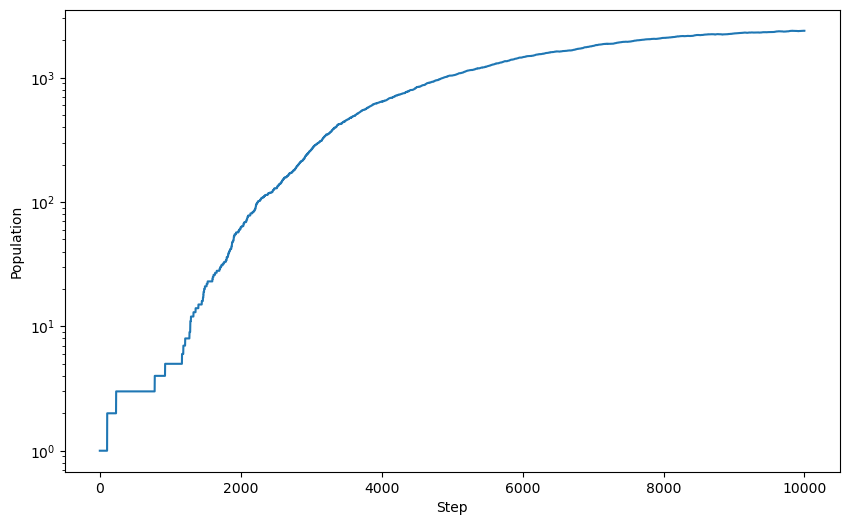

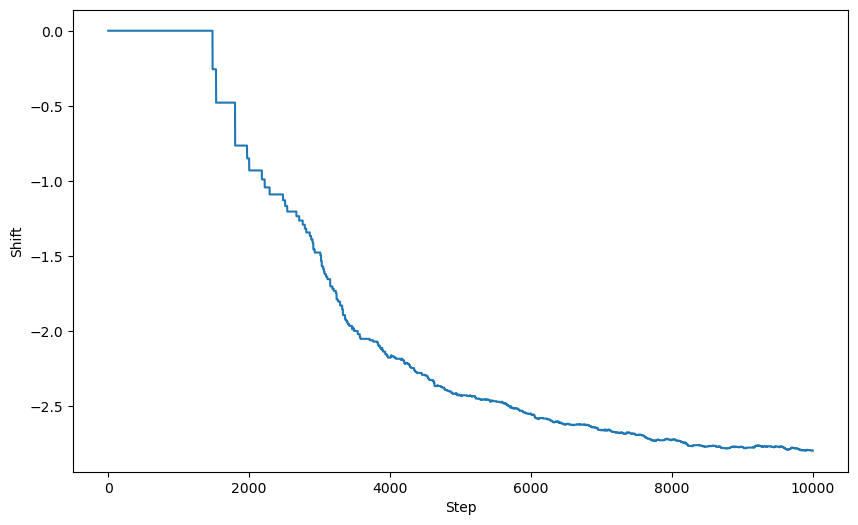

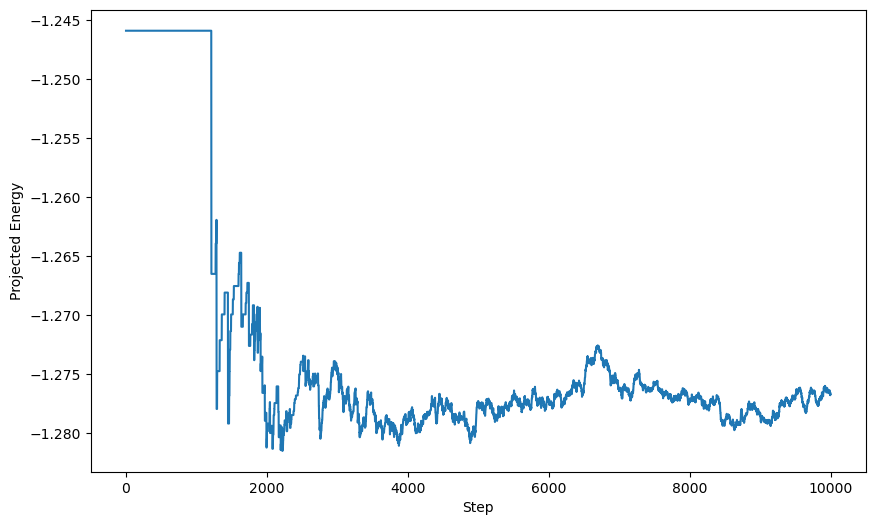

------------------------------
Final FCIQMC Energy: -1.277466 Ha


In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def FCIQMC_2(
    shift=0,
    init_n_walker=1,
    n_steps=10000,
    step_starting_shift_upd=800,
    shift_upd_interval=10,
    dt=0.001,
    damping=0.05):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて
    LiH 分子の基底状態エネルギーを推定する。

    Args:
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """
    # ---------- LiH の分子定義 ----------
    # 1 Å ≈ 1.889726125 Bohr
    # 文献値 R_e ≈ 3.015 Bohr → 約 1.59 Å
    # R = 1.59  # Angstrom
    
    # mol = gto.Mole()
    # mol.atom = f"""
    # Li 0 0 0
    # H  0 0 {R}
    # """
    # mol.unit = "Angstrom"
    # mol.basis = "cc-pVDZ"   # ここを cc-pVQZ に変えるだけで QZ 計算
    # mol.spin = 0            # LiH は (α,β) = (2,2) → 一重項
    # mol.build()
    mol = gto.M(
        atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
        basis = "sto-3g",
        charge = 1,
        spin = 0
    )
    H_mat, E_fci = build_hamiltonian2(mol)

    # H_mat, E_HF0 = build_hamiltonian2(mol)
    # H_mat = H_mat - E_HF0 * np.eye(H_mat.shape[0])

    print('E_fci:', E_fci)
    print(f"--- FCI Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps)):
        new_walkers = {}
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            # 通常は接続された決定基をランダムサンプリングするが、
            # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            
            for j in connected_dets:
                # 対角要素は自分自身への遷移を表すので処理しない
                if i == j: continue
                h_ij = row[j]

                # Spawning probability: Ps = dt * |H_ij|
                # 生成される数: sign(walker) * sign(-H_ij)
                # TODO: 分母のpgenは1？
                prob_spawn = dt * abs(h_ij)

                # 全てのwalkerに対して、spawnを試みる
                for k in range(n_i):            
                    if rng.random() <= prob_spawn:
                        # print(f'prob_spawn from {i} to {j}th determinant: ', prob_spawn)
                        if j not in new_walkers: new_walkers[j] = 0

                        n_spawn = 1
                        if prob_spawn >= 1:
                            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
                            n_spawn = prob_spawn_int + int(rng.random() < prob_spawn_frac) # 小数部分の確率でもう一つwalkerを追加で生成する

                        # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
                        if h_ij > 0:
                            new_walkers[j] += -np.sign(n_i) * n_spawn
                        else:
                            new_walkers[j] += np.sign(n_i) * n_spawn

            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            for k in range(abs(n_i)):
                if rng.random() <= abs(prob_death):
                    if prob_death > 0:
                        # prob_deathが正ならwalkerを一つ消滅させる
                        n_walker_on_D = sign * (abs(n_walker_on_D) - 1)
                    else:
                        # prob_deathが負ならwalkerを一つ複製する
                        n_walker_on_D = sign * (abs(n_walker_on_D) + 1)
            walkers[i] = n_walker_on_D

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        E_HF = diag_H[ref_det_idx]
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        # TODO: 論文にはない項を足している
        E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        # TODO: singles/doublesに限定する？
        
        if step % 1000 == 0:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                tqdm.write(f"  {v} walkers on {k}th determinant")

    E_est = np.mean(hist_energy[-1000:]) # 最後の1000ステップの平均
    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        print(f"{v} walkers on {k}th determinant")

    return E_est, hist_population, hist_shift, hist_energy



# --- 実行 ---
E_est, hist_population, hist_shift, hist_energy = FCIQMC_2()

plt.figure(figsize=(10, 6))
plt.plot(hist_population)
plt.xlabel('Step')
plt.ylabel('Population')
plt.yscale('log')

plt.figure(figsize=(10, 6))
plt.plot(hist_shift)
plt.xlabel('Step')
plt.ylabel('Shift')

plt.figure(figsize=(10, 6))
plt.plot(hist_energy)
plt.xlabel('Step')
plt.ylabel('Projected Energy')

plt.show()

# 正解値（厳密な対角化）との比較
print("-" * 30)
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")

# # PySCFの厳密解(FCI)
# # cisolver = fci.FCI(mol, scf.RHF(mol).run(verbose=0))
# # print(f"Exact FCI Energy   : {cisolver.kernel()[0]:.6f} Ha")

In [28]:
import numpy as np
from pyscf import gto, scf, ao2mo, fci

def build_fci_matrix_H2_sto3g(R=0.74):
    """最新の PySCF 3.x で H2(STO-3G) の FCI 行列を生成する"""
    
    # --- 1. 分子 ---
    mol = gto.M(
        atom=f'H 0 0 0; H 0 0 {R}',
        basis='sto-3g',
        unit='Angstrom',
        verbose=0
    )

    # --- 2. RHF ---
    mf = scf.RHF(mol).run(verbose=0)
    h1_ao = mf.get_hcore()
    eri_ao = mol.intor('int2e')
    C = mf.mo_coeff

    # --- 3. AO→MO ---
    h1 = C.T @ h1_ao @ C
    eri = ao2mo.incore.full(eri_ao, C)

    norb = h1.shape[0]
    nelec = mol.nelectron

    # --- 4. FCI 基底次元 ---
    cis = fci.direct_spin1.FCI()
    ndim = cis.make_hdiag(h1, eri, norb, nelec).size

    # --- 5. FCI 行列生成 ---
    H = np.zeros((ndim, ndim))

    # e_j = (0,0,...,1,...0)
    for j in range(ndim):
        ej = np.zeros(ndim)
        ej[j] = 1.0

        # H |j⟩ = (T + Vee) |j⟩
        H[:, j]  = cis.contract_1e(h1, ej, norb, nelec)
        H[:, j] += cis.contract_2e(eri, ej, norb, nelec)

    return H


# --- 実行 ---
if __name__ == "__main__":
    H = build_fci_matrix_H2_sto3g()
    print("FCI Hamiltonian matrix:")
    print(H)
    print("shape =", H.shape)


FCI Hamiltonian matrix:
[[ 5.54825058e-01 -1.99753668e-16 -1.99753668e-16  3.62420924e-01]
 [-1.65059199e-16  1.33387252e+00  3.62420924e-01  4.87196828e-16]
 [-1.65059199e-16  3.62420924e-01  1.33387252e+00  4.87196828e-16]
 [ 3.62420924e-01  5.21891298e-16  5.21891298e-16  2.20288924e+00]]
shape = (4, 4)


In [25]:
import numpy as np
from pyscf import gto, scf, ao2mo, fci

def create_ham_and_amps2():
    mol_UCC = gto.M(
        atom="He 0 0 0; H 0 0 1.463",
        basis="6-31g",
        charge=1,
        spin=0
    )
    elec_num = sum(mol_UCC.nelec)
    myhf = mol_UCC.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel()#run mp2
    C = myhf.mo_coeff #molecular coefficient matrix
    h1=np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2=ao2mo.kernel(mol_UCC,C)
    h2=ao2mo.restore(8,h2,mol_UCC.nao_nr())
    Ham = fci.direct_spin1.pspace(h1, h2, mol_UCC.nao_nr(), elec_num, np=70000)[1] #creates Hamiltonian
    nspatorbs = int(mol_UCC.nao_nr())
    print(Ham.shape)
    print(Ham)
    return elec_num,nspatorbs,Ham,mymp2.t2,myhf.energy_nuc(),h1,h2

elec_num,nspatorbs,Ham,doubles_amps,nuclear_en,h1,h2 = create_ham_and_amps2()

converged SCF energy = -2.86693503332257
E(RMP2) = -2.88007554749192  E_corr = -0.0131405141693497
E(SCS-RMP2) = -2.88270365032579  E_corr = -0.0157686170032196
(16, 16)
[[-3.59034886e+00 -1.01607611e-12 -1.14258256e-12  7.94642130e-13
  -1.01607611e-12  4.44217008e-02  1.23812466e-03  6.60460981e-02
  -1.14258256e-12  1.23812466e-03  5.87656406e-03 -6.63620284e-03
   7.94642130e-13  6.60460981e-02 -6.63620284e-03  2.11647555e-01]
 [-1.01607611e-12 -3.08334426e+00 -3.57912059e-02 -3.88849120e-02
   4.44217008e-02  1.87227483e-01  3.05654347e-02 -2.05819581e-02
   1.23812466e-03  1.40307852e-02  2.56408356e-02  7.67693982e-07
   6.60460981e-02  2.64016260e-01 -9.63888039e-04 -5.41584211e-02]
 [-1.14258256e-12 -3.57912059e-02 -2.10923842e+00  1.84822944e-02
   1.23812466e-03  3.05654347e-02  1.94884339e-01  1.86804048e-03
   5.87656406e-03  2.56408356e-02  1.83994276e-02 -1.03403473e-04
  -6.63620284e-03 -9.63888039e-04  2.81335479e-01  5.76190811e-03]
 [ 7.94642130e-13 -3.88849120e-02  

In [26]:
import numpy as np
from pyscf import gto, scf, ao2mo
from pyscf.fci import direct_spin1, cistring

mol = gto.M(
    atom="He 0 0 0; H 0 0 1.463",
    basis="6-31g",
    charge=1,
    spin=0
)

mf = scf.RHF(mol).run()

C = mf.mo_coeff
h1 = C.T @ mf.get_hcore() @ C

eri_compact = ao2mo.incore.full(mol.intor("int2e"), C)
eri = ao2mo.restore(1, eri_compact, h1.shape[0])

norb = h1.shape[0]   # ← 6 になる
na, nb = mol.nelec   # (1,1)

dim = cistring.num_strings(norb, na) * cistring.num_strings(norb, nb)
print("FCI dim =", dim)        # ← 36

H = np.zeros((dim, dim))
for j in range(dim):
    e = np.zeros(dim)
    e[j] = 1
    Hv = direct_spin1.contract_1e(h1, e, norb, (na,nb))
    Hv = direct_spin1.contract_2e(eri, Hv, norb, (na,nb))
    H[:,j] = Hv

print("H shape =", H.shape)     # ← (36,36)
print("H =", H)     # ← (36,36)


converged SCF energy = -2.86693503332257
FCI dim = 16
H shape = (16, 16)
H = [[-2.14361571e+01  2.13435599e+00 -3.67594072e-01  4.47261566e+00
   2.13435599e+00 -3.48654058e-01  1.80799652e-02 -5.34035133e-01
  -3.67594072e-01  1.80799652e-02 -8.13468650e-03  6.48530001e-02
   4.47261566e+00 -5.34035133e-01  6.48530001e-02 -9.77522544e-01]
 [ 2.28203122e+00 -1.01590607e+01 -1.29650436e+00 -1.46025900e+00
  -3.91924965e-01  4.91563644e-01 -2.36998720e-02  1.54340120e-01
   1.72730075e-02 -2.55634151e-01 -3.59324151e-02 -2.43046345e-02
  -5.83170427e-01  1.76663148e+00  1.64691682e-01  3.04931037e-01]
 [-5.28215696e-01 -1.75008805e+00 -6.78604232e+00  3.23426718e-01
   1.70707986e-02 -8.46326075e-02  4.21406608e-01 -2.70458996e-02
  -2.63600575e-02 -8.75259598e-02 -1.10810274e-01  4.23614527e-03
   7.94117703e-02  1.67361655e-01  1.05989619e+00 -6.23899999e-02]
 [ 6.49689699e+00 -1.96050496e+00  3.82796822e-01 -1.10154755e+01
  -7.70130251e-01  2.23803193e-01 -3.18536576e-02  1.20509407e